In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from src.preprocess.feature import *
from src.preprocess.make_dataset import *
from src.utils.plot import plot_labeled

In [3]:
model = tf.keras.models.load_model('models/cnn_1d_500.keras')

In [28]:
# Load the data
df_det = pd.read_csv('data/data.csv', parse_dates=['Date'], index_col=0, dtype={'Up Trend': 'object', 'Down Trend': 'object'})[:180]
windows, labels = get_window_dataset(df_det)

WINDOW_SIZE = 15
MIXED_LABEL = 1

X = np.array(windows)
X = normalize_windows(X)

# Step 1: Predict class probabilities
y_pred_probs = model.predict(X)
# Step 2: Convert predictions and true labels to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_padded = np.pad(y_pred, (0, WINDOW_SIZE - 1), mode='constant', constant_values=MIXED_LABEL)

y_pred_padded.shape, y_pred_padded

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


((180,),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], dtype=int64))

In [29]:
DOWNTREND_LABEL = 0
UPTREND_LABEL = 2

df_det['DownTrend'] = np.where(y_pred_padded == DOWNTREND_LABEL, 'DOWN', '')
df_det['UpTrend'] = np.where(y_pred_padded == UPTREND_LABEL, 'UP', '')

df_det

,Date,Open,High,Low,Close,UpTrend,DownTrend
0,2016-01-04,142.5,143.5,139.0,139.5,UP,
1,2016-01-05,139.0,140.0,137.0,138.0,UP,
2,2016-01-06,138.0,138.0,135.0,135.5,UP,
3,2016-01-07,134.5,135.0,130.5,133.0,UP,
4,2016-01-08,132.0,135.0,132.0,134.0,UP,
...,...,...,...,...,...,...,...
175,2016-09-22,185.0,185.5,183.5,185.5,,
176,2016-09-23,185.0,187.5,184.5,187.5,,
177,2016-09-26,183.5,185.0,183.0,183.0,,
178,2016-09-29,185.5,187.5,185.5,185.5,,


In [30]:
import pandas as pd
import numpy as np

# Step 1: Create masks
mask_down = df_det['DownTrend'] == 'DOWN'
mask_up = df_det['UpTrend'] == 'UP'

# Step 2: Create trend block IDs
df_det['DownTrendID'] = np.nan
df_det.loc[mask_down, 'DownTrendID'] = (
    (~mask_down.shift(fill_value=False)).cumsum()[mask_down]
)

df_det['UpTrendID'] = np.nan
df_det.loc[mask_up, 'UpTrendID'] = (
    (~mask_up.shift(fill_value=False)).cumsum()[mask_up]
)

# Step 3: Assign trend with ID to respective columns
df_det['DownTrend'] = np.where(
    mask_down, 'DOWN_' + df_det['DownTrendID'].astype('Int64').astype(str), ''
)

df_det['UpTrend'] = np.where(
    mask_up, 'UP_' + df_det['UpTrendID'].astype('Int64').astype(str), ''
)

# Step 4: Drop helper columns
df_det.drop(columns=['DownTrendID', 'UpTrendID'], inplace=True)

df_det['UpTrend'].replace('', np.nan, inplace=True)
df_det['DownTrend'].replace('', np.nan, inplace=True)

df_det

C:\Users\nick\AppData\Local\Temp\ipykernel_10084\2908082837.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_det['UpTrend'].replace('', np.nan, inplace=True)
C:\Users\nick\AppData\Local\Temp\ipykernel_10084\2908082837.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

,Date,Open,High,Low,Close,UpTrend,DownTrend
0,2016-01-04,142.5,143.5,139.0,139.5,UP_1,NaN
1,2016-01-05,139.0,140.0,137.0,138.0,UP_1,NaN
2,2016-01-06,138.0,138.0,135.0,135.5,UP_1,NaN
3,2016-01-07,134.5,135.0,130.5,133.0,UP_1,NaN
4,2016-01-08,132.0,135.0,132.0,134.0,UP_1,NaN
...,...,...,...,...,...,...,...
175,2016-09-22,185.0,185.5,183.5,185.5,NaN,NaN
176,2016-09-23,185.0,187.5,184.5,187.5,NaN,NaN
177,2016-09-26,183.5,185.0,183.0,183.0,NaN,NaN
178,2016-09-29,185.5,187.5,185.5,185.5,NaN,NaN


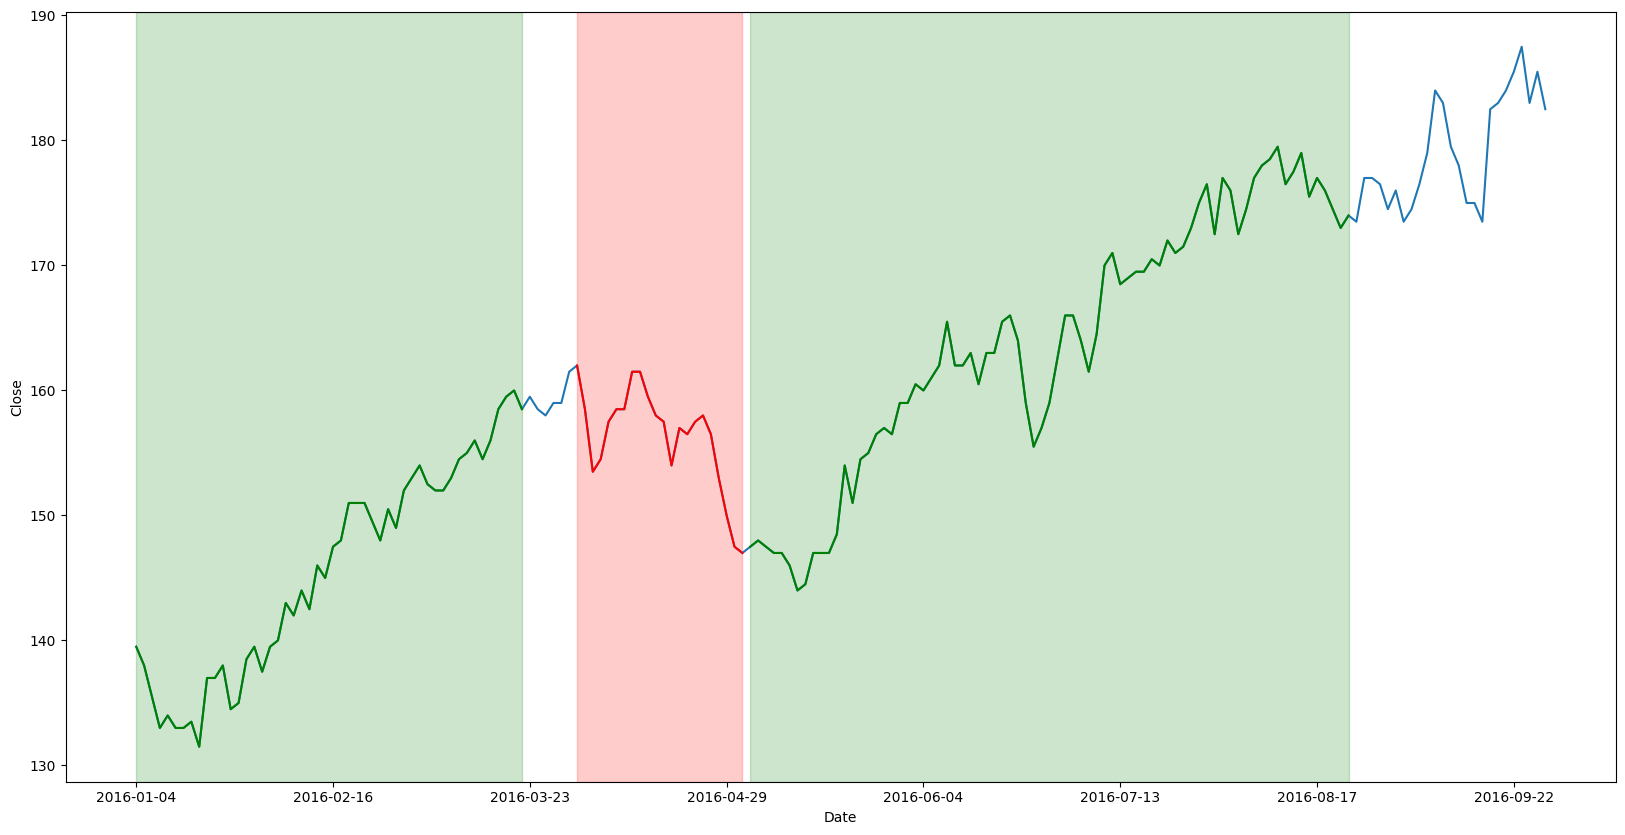

In [31]:
from src.utils.plot import plot_labeled

plot_labeled(df_det.copy())